This notebook performs the unfolding with a neural network. Itq does a series of things.
1. Simulates 1n,2n detection and saves truth,observations in 2D histograms
2. Plots the truth and observation together for visual inspection
3. Pre-processing of data for neural network
4. Creates a neural network (fully-connected feed forward)
5. Trains the neural network
6. Performs unfolding on test set and plots 16 examples with the truth values

In [5]:
import matplotlib.pylab as pylab

In [1]:
# Basic libraries
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Network
from keras.models import Sequential
from keras.layers import Dense

# My modules
from modules.efficiency_matrix import effmatrix

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set random seed

In [2]:
seed = 11
np.random.seed(seed)

Parameters for the data set

In [3]:
# upper limits of the histograms. lower limits = 0
x_max = 60
y_max = 60
incr = 1 # for loop increment

# this defines the rectangular region we sample (1n,2n) truth values from
min1n = 10
max1n = 30
min2n = 0
max2n = 30

# how many times we sample the 2D-poisson dist. at a given (1n,2n) truth value
nsamples = 1000 #1000

# HALO efficiency matrix
M = effmatrix()

Create a training set by generating a list of truth,observed histograms

In [4]:
truth_set = []
obs_set   = []


for i in range(min1n,max1n+1,incr):
    for j in range(min2n,max2n+1,incr):
        
        # empty arrays for truth and observed values
        nbins = (x_max + 1)*(y_max + 1)
        truth = np.zeros(nbins)
        obs   = np.zeros(nbins)

        for k in range(nsamples):
            
            # truth distribution
            oneN = np.random.poisson(i)
            twoN = np.random.poisson(j)

            # calculate observed distribution
            oneN_obs = 0
            twoN_obs = 0
            for n in range(oneN):
                rand = np.random.random()
                if rand < M.item(0,0):
                    oneN_obs += 1
            for n in range(twoN):
                rand = np.random.random()
                if rand < M.item(0,1):
                    oneN_obs += 1
                elif rand < M.item(0,1) + M.item(1,1):
                    twoN_obs += 1
            
            # add truth,observation to arrays
            i_truth = oneN + (x_max + 1)*twoN
            truth[i_truth] += 1
            i_obs = oneN_obs + (x_max + 1)*twoN_obs
            obs[i_obs] += 1

        # add arrays to set
        truth_set.append(truth)
        obs_set.append(obs)


Plot a random truth,observation pair from the training set

(0, 60)

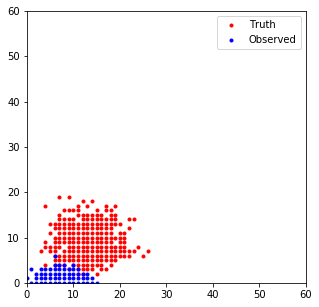

In [6]:
# pick a random plot number to view
plot_num = np.random.randint(0,len(truth_set))
truth_plot = truth_set[plot_num]
obs_plot = obs_set[plot_num]

# TRUTH
# arrays for scatter plot
truth_x_values = []
truth_y_values = []
# fill arrays
for i in range(len(truth_plot)):
    if truth_plot[i] > 0:
        # calculate x,y values from index
        xval = i % (x_max + 1)
        yval = i // (x_max + 1)
        # add x,y to arrays for scatter plot
        truth_x_values.append(xval)
        truth_y_values.append(yval)

# OBSERVED
# arrays for scatter plot
obs_x_values = []
obs_y_values = []
# fill arrays
for i in range(len(obs_plot)):
    if obs_plot[i] > 0:
        # calculate x,y values from index
        xval = i % (x_max + 1)
        yval = i // (x_max + 1)
        # add x,y to arrays for scatter plot
        obs_x_values.append(xval)
        obs_y_values.append(yval)

# make the plot
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )  # create figure & 1 axis
            
ax.scatter(truth_x_values,truth_y_values,c='r',marker='.',label='Truth')
ax.scatter(obs_x_values,obs_y_values,c='b',marker='.',label='Observed')
ax.legend()
ax.set_xlim([0,x_max])
ax.set_ylim([0,y_max])

Standardize the data. Many training algorithms behave poorly if the data isn't (approximately) normally distributed (i.e. Gaussian with mean = 0 and unit variance)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the scaler
scaler.fit(obs_set)
# standardize the data
obs_set = scaler.transform(obs_set)
# maybe standardize the truth values as well?
#truth_set_flat = scaler.transform(truth_set)

The neural network. It is a fully-connected (dense) feed-forward neural network.

In [8]:
width = (x_max+1)*(y_max+1) # how many nodes in input
epochs = 5
batch_size = 32

model = Sequential()
model.add(Dense(width, input_dim=width, kernel_initializer='normal', activation='relu'))
model.add(Dense(width, kernel_initializer='normal', activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(obs_set, np.array(truth_set), epochs=epochs, batch_size=batch_size,verbose=1)

Epoch 1/5
651/651 [==============================] - 12s 19ms/step - loss: 1.9424 - acc: 0.9259
Epoch 2/5
651/651 [==============================] - 11s 17ms/step - loss: 1.7352 - acc: 0.9259
Epoch 3/5
651/651 [==============================] - 11s 17ms/step - loss: 1.6718 - acc: 0.9259
Epoch 4/5
651/651 [==============================] - 11s 17ms/step - loss: 1.6308 - acc: 0.9259
Epoch 5/5
651/651 [==============================] - 11s 17ms/step - loss: 1.6015 - acc: 0.9259


Unfold with the neural network

In [9]:
unfolded_set = model.predict(obs_set)

Plot 16 examples of the unfolding

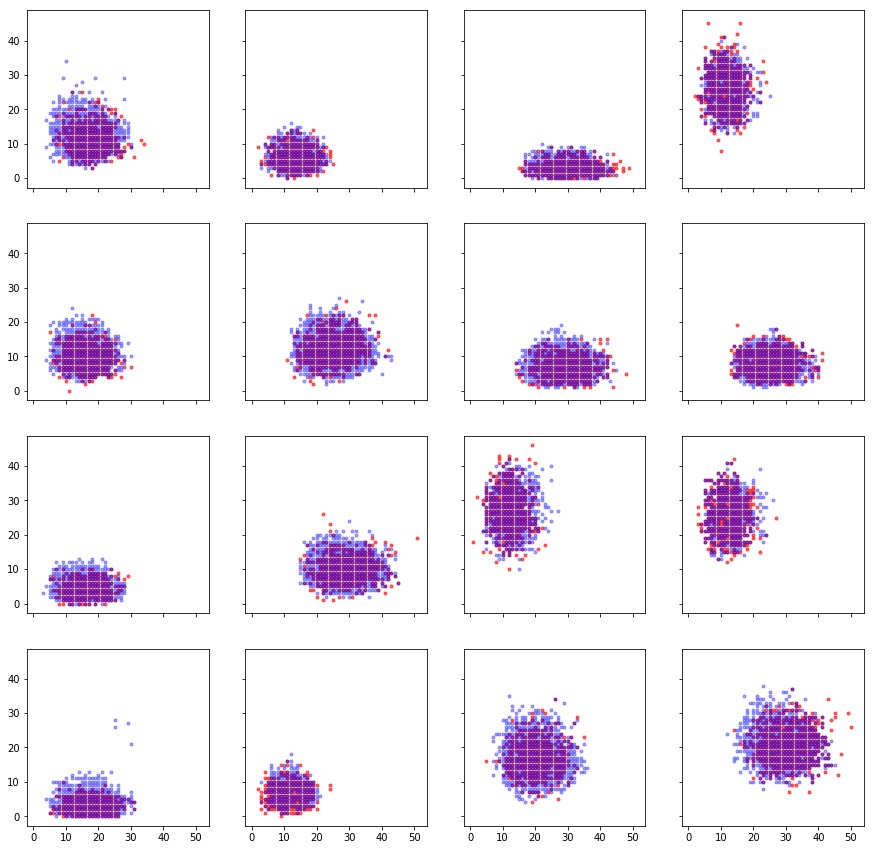

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(unfolded_set))
    unfolded_plot = unfolded_set[plot_num]
    truth_plot = truth_set[plot_num]
    
    # Selecting the appropriate cut
    unfolded_sort = -np.sort(-unfolded_plot)
    tot_prob = 0
    for i in unfolded_sort:
        tot_prob += i
        if tot_prob >= 0.98:
            cut = i
            break

    # UNFOLDED
    # arrays for scatter plot
    unfolded_x_values = []
    unfolded_y_values = []
    # fill arrays
    for i in range(len(unfolded_plot)):
        if unfolded_plot[i] > cut:
            # calculate x,y values from index
            xval = i % (x_max + 1)
            yval = i // (x_max + 1)
            # add x,y to arrays for scatter plot
            unfolded_x_values.append(xval)
            unfolded_y_values.append(yval)
      
    # TRUTH
    # arrays for scatter plot
    truth_x_values = []
    truth_y_values = []
    # fill arrays
    for i in range(len(truth_plot)):
        if truth_plot[i] > 0:
            # calculate x,y values from index
            xval = i % (x_max + 1)
            yval = i // (x_max + 1)
            # add x,y to arrays for scatter plot
            truth_x_values.append(xval)
            truth_y_values.append(yval)
            
    axs[plot_].scatter(truth_x_values,truth_y_values,c='r',marker='.',alpha=0.6)
    axs[plot_].scatter(unfolded_x_values,unfolded_y_values,c='b',marker='.',alpha=0.35)
    
pylab.savefig("for_pres.png")

-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
Now I want to test an individual point, like what will be recorded in the event of a real supernova

In [10]:
truth_set = []
obs_set   = []


for i in range(min1n,max1n+1,incr):
    for j in range(min2n,max2n+1,incr):
        
        # empty arrays for truth and observed values
        nbins = (x_max + 1)*(y_max + 1)
        truth = []
        obs   = np.zeros(nbins)

        oneN = i
        twoN = j
        
        truth = [oneN,twoN]
        
        # calculate observed numbers
        oneN_obs = 0
        twoN_obs = 0
        for n in range(oneN):
            rand = np.random.random()
            if rand < M.item(0,0):
                oneN_obs += 1
        for n in range(twoN):
            rand = np.random.random()
            if rand < M.item(0,1):
                oneN_obs += 1
            elif rand < M.item(0,1) + M.item(1,1):
                twoN_obs += 1
                
        for k in range(nsamples):
            
            # truth distribution
            oneN_obs_ = np.random.poisson(oneN_obs)
            twoN_obs_ = np.random.poisson(twoN_obs)
            
            # add observations to array
            i_obs = oneN_obs_ + (x_max + 1)*twoN_obs_
            obs[i_obs] += 1


        # add arrays to set
        truth_set.append(truth)
        obs_set.append(obs)


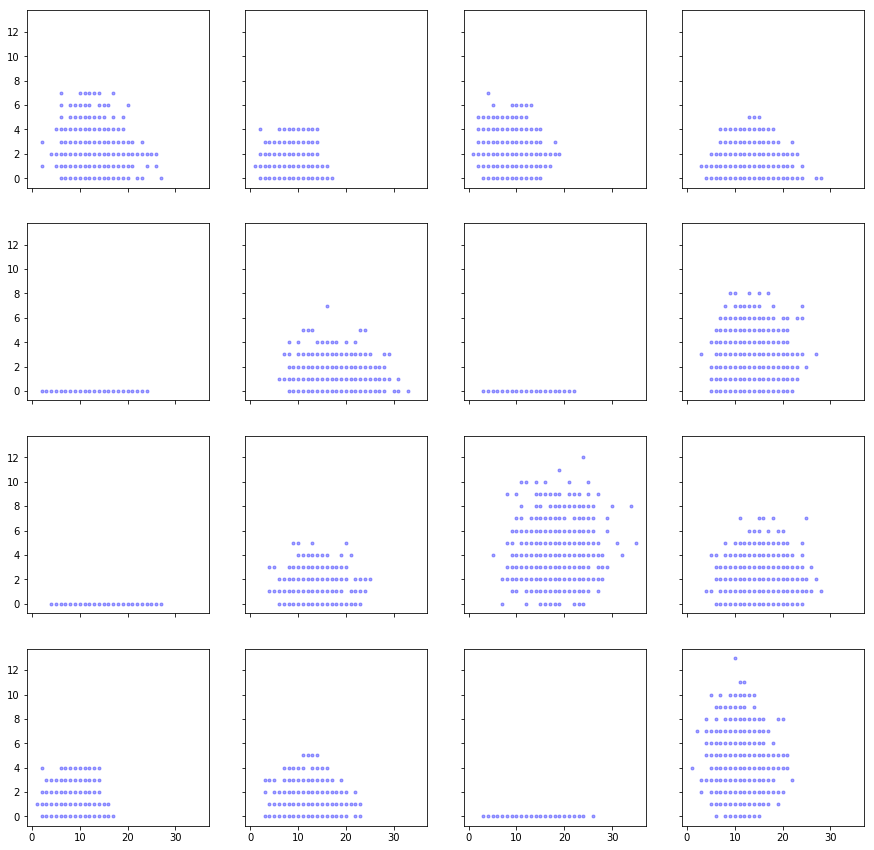

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(unfolded_set))
    obs_plot = obs_set[plot_num]
    
    # Observed
    # arrays for scatter plot
    obs_x_values = []
    obs_y_values = []
    # fill arrays
    for i in range(len(obs_plot)):
        if obs_plot[i] > 0:
            # calculate x,y values from index
            xval = i % (x_max + 1)
            yval = i // (x_max + 1)
            # add x,y to arrays for scatter plot
            obs_x_values.append(xval)
            obs_y_values.append(yval)
            
    axs[plot_].scatter(obs_x_values,obs_y_values,c='b',marker='.',alpha=0.35)

In [12]:
unfolded_set = model.predict(np.array(obs_set))

CUT = 0.18838148
0.9999999356077804
CUT = 0.99874806
0.9999999265436021
CUT = 0.1253255
1.0000000392581871
CUT = 0.9994248
1.0000000269829776
CUT = 0.99754566
0.9999998035528428
CUT = 0.9999757
0.9999999863678629
CUT = 0.99998546
1.0000000263360305
CUT = 0.99947566
1.0000000085587564
CUT = 0.11195738
1.0000002154409688
CUT = 0.980988
1.0000003472866619
CUT = 0.10387878
1.000000359849208
CUT = 0.99622846
1.000000043624673
CUT = 0.087760024
0.9999998914341843
CUT = 0.9673498
1.0000001554144586
CUT = 0.42152
0.999999870178474
CUT = 0.010535147
1.0000001730377592


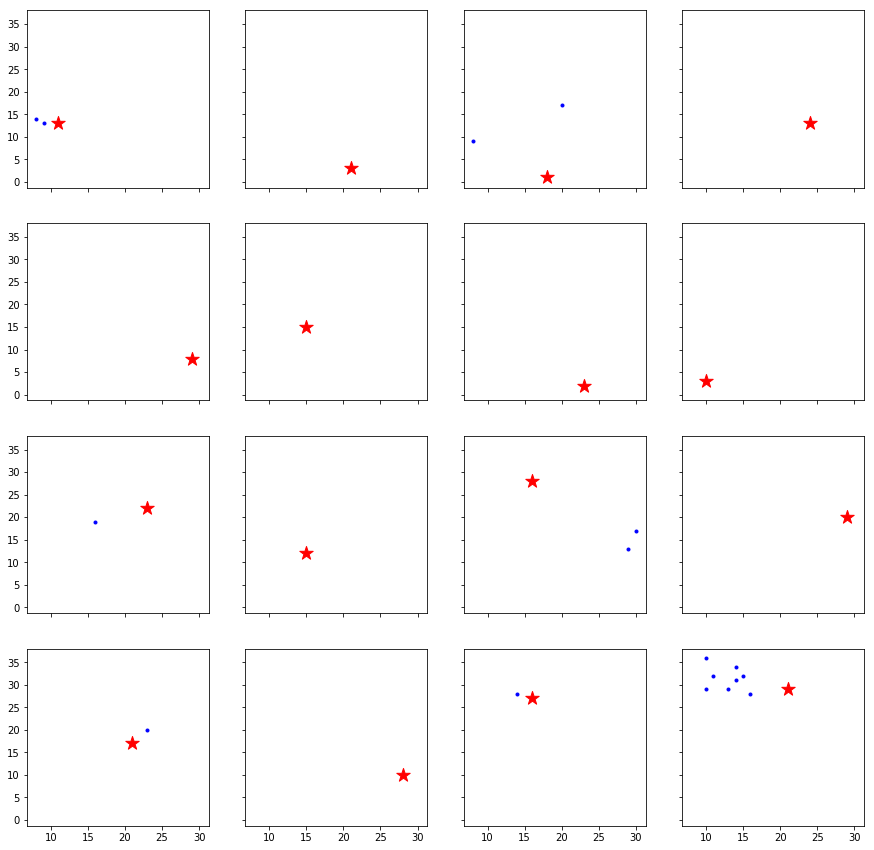

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(unfolded_set))
    unfolded_plot = unfolded_set[plot_num]
    truth_plot = truth_set[plot_num]
    
    # Selecting the appropriate cut
    unfolded_sort = -np.sort(-unfolded_plot)
    tot_prob = 0
    cut = 0
    for i in unfolded_sort:
        tot_prob += i
        if tot_prob >= 0.9:
            cut = i
            break
    print("CUT =",cut)
    print(sum(unfolded_sort)) 
    
    # UNFOLDED
    # arrays for scatter plot
    unfolded_x_values = []
    unfolded_y_values = []
    # fill arrays
    #cut = 0.0001
    for i in range(len(unfolded_plot)):
        if unfolded_plot[i] > cut:
            # calculate x,y values from index
            xval = i % (x_max + 1)
            yval = i // (x_max + 1)
            # add x,y to arrays for scatter plot
            unfolded_x_values.append(xval)
            unfolded_y_values.append(yval)
            
    axs[plot_].scatter(unfolded_x_values,unfolded_y_values,c='b',marker='.',alpha=1)
    axs[plot_].scatter(truth_plot[0],truth_plot[1],c='r',marker='*',s=200)

Try training this same way. Take a single point, calculate observed, poisson fluctuate, then give those fluctuations plus the single truth point to the network.